# Introduction

Analyse exploratoire des données importées via l'outil stackexchange explorer.

##### Contexte

Création d'un système de suggestion de tags pour le site stackoverflow. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

##### Récupération des données

Pour l'analyse exploratoire, j'ai récupéré l'ensemble des posts (uniquement les questions PostTypeId = 1) créés sur le site stackoverflow depuis sa création.

Je me suis focalisé sur les posts d'utilisateurs expérimentés (Réputation >= 10000, nombre de vues >= 5000).

Comme stackexchange explorer ne permet de collecter que maximum 50000 records à la fois, j'ai utilisé le champ Id de la table Posts pour découper mes requêtes.

##### Exemple de requête:

SELECT Title, Body, Tags 

FROM Posts p, Users u 

WHERE p.OwnerUserId = u.Id 

AND p.Id <= 1000000 

AND PostTypeId = 1

AND Reputation >= 10000

AND Views >= 5000

AND Score IS NOT NULL

AND ViewCount IS NOT NULL

AND AnswerCount IS NOT NULL

AND CommentCount IS NOT NULL

AND FavoriteCount IS NOT NULL

AND Tags IS NOT NULL

In [1]:
# misc
import os
import re
import time
import joblib
import warnings
import numpy as np
import pandas as pd

# preprocessing
import nltk
import spacy
from bs4 import BeautifulSoup
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# lda
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# wordcloud
from wordcloud import WordCloud

# Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\james\anaconda3\envs\p5\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Requested for nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')

# Inactivate warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


# Chargement des données

In [3]:
# New dataframe instanciation
data = pd.DataFrame()

# Process files
for idx, file in enumerate(os.listdir('./data')):
    print(idx, '-', file)
    path = './data/' + file
    df = pd.read_csv(path)
        
    data = pd.concat([data, df],
                      axis=0)

# Reset index
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

0 - QueryResults_1.csv
1 - QueryResults_20.csv
2 - QueryResults_40.csv
3 - QueryResults_5.csv
4 - QueryResults_70.csv


# Analyse de forme

## Variables

In [4]:
data.columns

Index(['Title', 'Body', 'Tags'], dtype='object')

##### 2 groupes de variables:

- Titre et corps des posts
- Tags

## Variable target

In [5]:
data['Tags'][0]

'<c++><boost-graph>'

La variable Tags est une chaîne de caractères.

## Lignes et colonnes

In [6]:
print("Premières valeurs du dataset")
display(data.head())
print('\n' + '-' *50 +'\n')
print(f"Nombre d'observations: {data.shape[0]}, nombre de variables: {data.shape[1]}")

Premières valeurs du dataset


,Title,Body,Tags
0,How to create a C++ Boost undirected graph and...,<p>How to create a C++ Boost undirected graph ...,<c++><boost-graph>
1,Enabling OpenGL in wxWidgets,"<p>I installed the wxWidgets source code, comp...",<opengl><wxwidgets>
2,Strange C++ errors with code that has min()/ma...,<p>I'm seeing strange errors when my C++ code ...,<c++><c>
3,Using GLUT with Visual C++ Express Edition,<p>What are the basic steps to compile an Open...,<visual-studio><visual-c++><opengl><glut>
4,Increasing camera capture resolution in OpenCV,"<p>In my C/C++ program, I'm using <a href=""htt...",<c><image><opencv><webcam><resolutions>



--------------------------------------------------

Nombre d'observations: 107376, nombre de variables: 3


## Types de variables

In [7]:
data.dtypes.value_counts()

object    3
dtype: int64

Variables qualitatives : 3, quantitatives : 0

## Valeurs manquantes

In [8]:
data.isnull().any()

Title    False
Body     False
Tags     False
dtype: bool

Pas de valeurs manquantes

# Analyse de fond

## Visualisation de la target

In [9]:
# Split tags in a list
def split_tags(df):
    record = df['Tags'].replace('<', '').split('>')
    record = record[:-1]
    return record


data['Tags_list'] = data.apply(split_tags, axis=1)

In [10]:
# Count the tags in the tags list
def tags_number(df):
    return len(df['Tags_list'])


data['tags_number'] = data.apply(tags_number, axis=1)

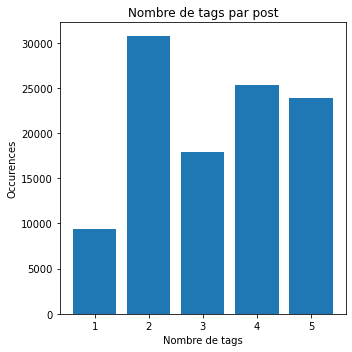

In [11]:
fig = plt.figure(figsize=(5, 5))
plt.bar(data['tags_number'].unique(), data['tags_number'].value_counts())
plt.title('Nombre de tags par post')
plt.xlabel('Nombre de tags')
plt.ylabel('Occurences')
plt.tight_layout()
plt.gcf().savefig('init_nomber_tags_post', dpi=100)
plt.show()

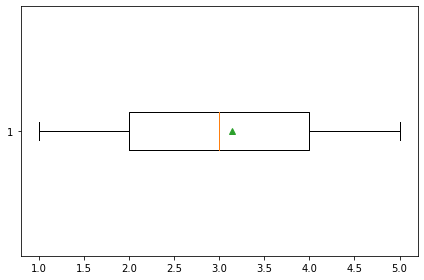

In [12]:
plt.boxplot(data['tags_number'], vert=False, showmeans=True, showfliers=False)
plt.tight_layout()
plt.gcf().savefig('boxplot_tags_number', dpi=100)
plt.show()

Le nombre de tags par post a une distribution empirique de 1 à 5 avec une médiane à 3 tags.

## Titre et corps des posts

In [13]:
def getFreq(df, column, topMostNum, topLessNum, displaySingle):
    # List the most frequent words in column
    wordsFrequences = {}
    final_words = {}

    for index, row in df.iterrows():
        try:
            title = row[column].split(' ')
        except:
            title = row[column]
            
        for word in title:
            if word in wordsFrequences.keys():
                wordsFrequences[word] += 1
            else:
                wordsFrequences[word] = 1

    print('Variable:', column)
    print('Nombre de mots uniques:', len(wordsFrequences))

    # Sort by number of occurence
    sorted_keys = sorted(wordsFrequences, key=wordsFrequences.get, reverse=True)  

    # Filter to get the top most frequent words defined by parameter topMostNum
    for w in sorted_keys:
        final_words[w] = wordsFrequences[w]
        if len(final_words) == topMostNum:
            break

    # Display graph
    fig = plt.figure(figsize=(12, 5))
    plt.bar(final_words.keys(), final_words.values())
    plt.title('Les ' + str(topMostNum) + ' mots les plus fréquents dans la colonne ' + column)
    plt.xlabel('Mots')
    plt.ylabel('Occurences')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.gcf().savefig('most_frequent_words_' + column, dpi=100)
    plt.show()
    
    # Sort by number of occurence
    sorted_keys = sorted(wordsFrequences, key=wordsFrequences.get, reverse=False) 
    
    # Filter to get the top less frequent words defined by parameter topLessNum
    final_words.clear()
    
    for w in sorted_keys:
        if wordsFrequences[w] == 1:
            final_words[w] = wordsFrequences[w]

    print('Nombre de mots rencontrés une seule fois:', len(final_words))
    print('')
    
    # Filter on number of words defined by parameter topLessNum
    if displaySingle:
        print('Les ' + str(topLessNum) + ' premiers mots rencontrés une seule fois dans la colonne ' + column + ':')
        print('')
        
        count = 0
        wordsList = []
        for key in final_words.keys():
            count += 1
            wordsList.append(key)
            if count == topLessNum:
                break
                
        print(wordsList)
    
    return final_words

Variable: Title
Nombre de mots uniques: 89708


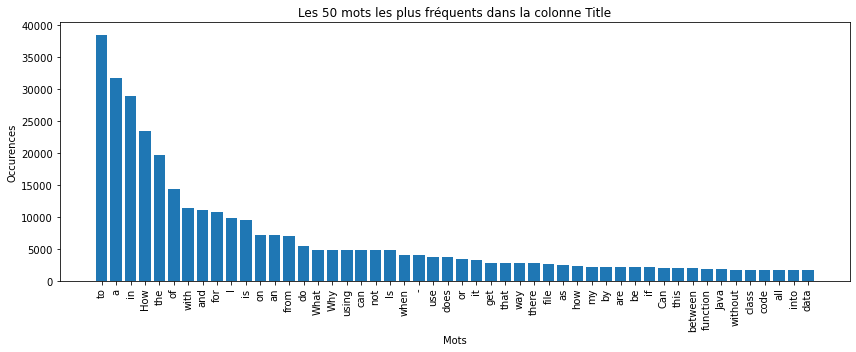

Nombre de mots rencontrés une seule fois: 60215

Les 50 premiers mots rencontrés une seule fois dans la colonne Title:

['(DFS)', 'min()/max()', '2009?', 'System.Data.SqlClient.SqlException:', 'Proportional', 'Management"', 'Failure"', 'Locked', 'Workstation?', 'continuations!', '"tail', 'HP-UX', 'scrollwheel', 'ndepend?', '(.csproj)', 'purposes)?', '(sender,', 'EventArgs)?', 'VS2005/8', '"Exit', 'Method"', '(Byte', 'Mark)', 'System.Drawing.Color?', 'ObjectMother?', '(Agile', 'programming)', 'Debug?', 'rush', "dotnet's", 'char.IsLower()', '.NET/C#', 'Release/Debug', 'OpenSocial', 'HashSet<T>.IsReadOnly', 'Cross-language', 'reintegrate-merged', 'Ctrl-tab', 'facade', '"unuse"', 'disguise?', '".dll.a"', '/or', '"tree"', 'MIBs?', '(.Net/C#', 'DependencyProperties', 'GetProcessID', 'Integer-type', 'Boost::Tuples']


In [14]:
freq1title = getFreq(data, 'Title', 50, 50, True)

- Stopwords, ponctuation et majuscules à nettoyer
- 67% des mots ne sont rencontrés qu'une seule fois
- Les mots rencontrés une seule fois correspondent souvent à un vocabulaire technique

Variable: Body
Nombre de mots uniques: 2019523


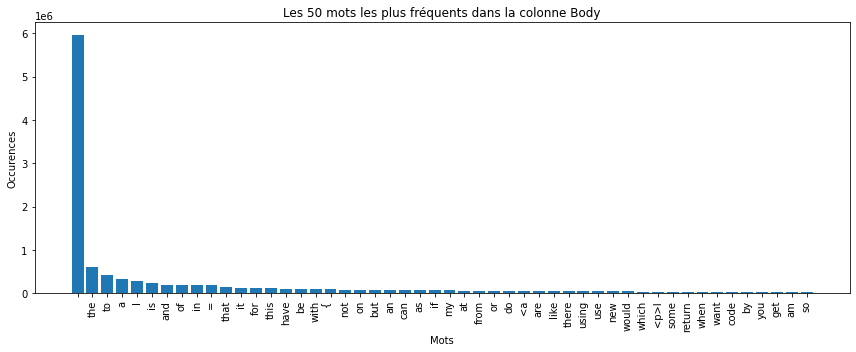

Nombre de mots rencontrés une seule fois: 1593366

Les 100 premiers mots rencontrés une seule fois dans la colonne Body:

['(DFS)', '<em>GLUT', 'Toolkit)</em>', 'Edition?</p>\n', 'href="http://opencvlibrary.sourceforge.net/"', 'href="http://en.wikipedia.org/wiki/Quickcam"', 'rel="noreferrer">Logitech', 'QuickCam', 'IM</a>)', '<strong>320x240</strong>,', '<strong>640x480</strong>', '<strong>1280x960</strong>.', '<strong>320x240</strong>', '<strong>cvSetCaptureProperty()</strong>', 'webcam?</p>\n', 'BCB5', 'ECB2009', 'called.</p>\n\n<p>Some', 'TNT/TMS', 'UnicodeString,', 'c_str', 'BCB2007', 'necessary.</p>\n\n<p>Particular', 'are:</p>\n\n<ul>\n<li>Passing', 'API\nfunctions</li>\n<li>Interop', "TXMLDocument</li>\n<li>'Raw'", 'etc.</li>\n</ul>\n\n<p>Rather', 'knife-and-fork', '<p><code>System.Data.SqlClient.SqlException:', 'closed.</code></p>\n\n<p>Anybody', 'href="http://forums.microsoft.com/MSDN/ShowPost.aspx?PostID=125227&amp;SiteID=1"', 'information.</a></p>\n\n<p><strong>Update</stron

In [15]:
freq1body = getFreq(data, 'Body', 50, 100, True)

- Présence de balises html
- Présence de code et scripts
- 79% des mots ne sont rencontrés qu'une seule fois
- Les mots rencontrés une seule fois correspondent souvent à des bouts de scripts

# Filtrage des données

Je filtre pour ne conserver que les posts ayant des tags parmi les 50 tags les plus fréquents.

In [16]:
# List the most frequent tags
tagsFrequences = {}
final = {}

for index, row in data.iterrows():
    title = row['Tags_list']

    for word in title:
        if word in tagsFrequences.keys():
            tagsFrequences[word] += 1
        else:
            tagsFrequences[word] = 1

print('Nombre de tags uniques:', len(tagsFrequences))

# Sort by number of occurence
sorted_keys = sorted(tagsFrequences, key=tagsFrequences.get, reverse=True)  

# Filter to get the top 50 most frequent tags
for w in sorted_keys:
    final[w] = tagsFrequences[w]
    if len(final) == 50:
        break

Nombre de tags uniques: 19535


In [17]:
def most_frequent_tag_filter(df):
    boo_test = False

    taglist = df['Tags_list']
    for i in range(0, len(taglist)):
        if taglist[i] in final.keys():
            boo_test = True
        else:
            boo_test = False
            break

    return boo_test


Filter = data.apply(most_frequent_tag_filter, axis=1)
filtered_data = data[Filter]

print(
    f"Nombre d'observations: {filtered_data.shape[0]}, nombre de variables: {filtered_data.shape[1]}")
print(
    f"Proportion d'observations sélectionnées: {round(filtered_data.shape[0] / data.shape[0]*100,3)}%")

Nombre d'observations: 10247, nombre de variables: 5
Proportion d'observations sélectionnées: 9.543%


# Cleaning des données

## Définition des fonctions

In [18]:
# Tokenisation
# \w+ matches any word character (equal to [a-zA-Z0-9])
tokenizer = nltk.RegexpTokenizer(r'\w+')

In [19]:
# Stopwords definition
all_stopwords = stopwords.words('english')

In [20]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

In [21]:
# Delete numbers
r = re.compile(".*[a-zA-Z]")

In [22]:
# Delete verbs with Part of speech (POS)
pos = spacy.load("en_core_web_sm")

In [23]:
def preprocessing(text):
    # HTML cleaning
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove punctuation
    text = re.sub('[,;:.!?_]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenisation
    text = tokenizer.tokenize(text)

    # Stopwords deletion
    text = [word for word in text
            if not word in all_stopwords]

    # Lemmatization
    result = []
    for word in text:
        result.append(lemmatizer.lemmatize(word))
    text = result

    # Delete numbers
    text = list(filter(r.match, text))
    
    # PRON, AUX, ADV, ADJ, PART, VERB, DET, NOUN, ADP
    # Remove AUX, VERB
    result = []
    doc = pos(' '.join(text))
    for token in doc:
        if token.pos_ != 'AUX' and token.pos_ != 'VERB':
            result.append(token.text)
    text = result

    return text

In [24]:
def token_to_string(df):
    return ' '.join(df['list_tokens'])

# Columns deletion
def drop(df, col_list):
    df = df.drop(col_list, axis=1)
    return df

# -----------------------------------------------
# Feature engineering

# Number of characters per post
def post_char_count(df):
    return len(''.join(df['list_tokens']))

# Number of tokens per post
def post_token_count(df):
    return len(df['list_tokens'])

# Average number of characters per word
def post_avg_wordlength(df):
    return df['post_char_count'] / df['post_token_count']

## Preprocessing

### Merging Title et Body

In [25]:
filtered_data['text'] = filtered_data['Title'] + ' ' + filtered_data['Body']

### Preprocess text

In [26]:
filtered_data['list_tokens'] = filtered_data['text'].apply(lambda x: preprocessing(x))

In [27]:
filtered_data['str_tokens'] = filtered_data.apply(token_to_string, axis=1)

### Mots rencontrés une seule fois

Variable: str_tokens
Nombre de mots uniques: 48611


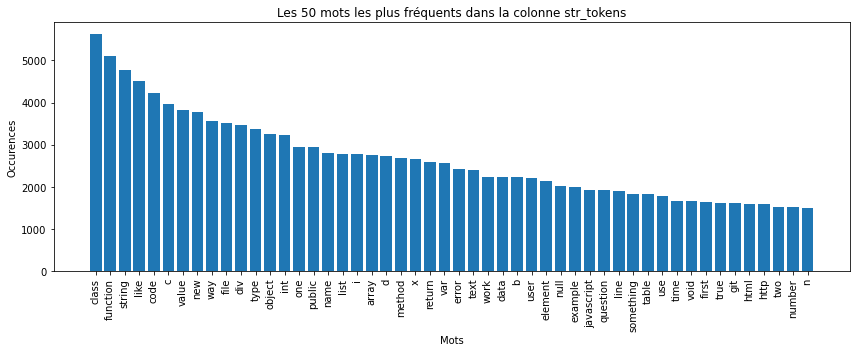

Nombre de mots rencontrés une seule fois: 25567

Les 100 premiers mots rencontrés une seule fois dans la colonne str_tokens:

['cleanliness', 'courtesy', 'dod', 'foocsproj', 'jaredpar', 'straw', 'continuum', 'brianpeiris', 'amd', 'turion', 'frustrate', 'smallish', 'spolsky', 'minindex', 'listfindmin', 'subcatcode', 'partsskip', 'hop', 'dependencyproperties', 'shellexecuteex', 'enumwindows', 'enumproc', 'getwindowthreadprocessid', 'setresult', 'codegear', 'forestall', 'mro', 'myclassmro', 'genericfactory', 'otherfactory', 'furniture', 'wwwprojecteulernet', 'inauguration', 'ielem', 'yuval', 'nag', 'licensed', 'snippet1', 'snippet2', 'tidbit', 'soe', 'httpxforwardfor', 'applyrange', 'todate', 'datecivil', 'barf', 'unitycontainerkey', 'getcontainer', 'applicationlock', 'unitycontainer', 'applicationunlock', 'bravo', 'wiz', 'blazingly', 'interrelated', 'snexe', 'snk', 'internalsvisibleto', 'interruptible', 'signalh', 'unistdh', 'getpid', 'sigusr1', 'servthstart', 'oskill', 'osgetpid', 'kill

In [28]:
freq1_str_tokens = getFreq(filtered_data, 'str_tokens', 50, 100, True)

Je ne conserve dans freq1_str_tokens que les termes qui ne font pas partis du vocabulaire anglais.

In [29]:
# nltk list of english vocabulary
vocab = set(words.words())

In [30]:
freq1_str_tokens = [word for word in freq1_str_tokens
            if not word in vocab]

Je supprime les mots rencontrés une seule fois car ils correspondent le plus souvent à des fautes de frappe.

In [31]:
def removeOneTimeWords(text):
    # Remove unique words
    text = [word for word in text
            if not word in freq1_str_tokens]
    
    return text

In [32]:
filtered_data['list_tokens'] = filtered_data['list_tokens'].apply(lambda x: removeOneTimeWords(x))

In [33]:
filtered_data['str_tokens'] = filtered_data.apply(token_to_string, axis=1)

### Features engineering

In [34]:
# Number of characters per post
filtered_data['post_char_count'] = filtered_data.apply(post_char_count, axis=1)

# Number of tokens per post
filtered_data['post_token_count'] = filtered_data.apply(post_token_count, axis=1)

# Remove post without words
filtered_data = filtered_data[filtered_data['post_token_count'] != 0]

# Average number of characters per word
filtered_data['post_avg_wordlength'] = filtered_data.apply(post_avg_wordlength, axis=1)

### Suppression des colonnes inutiles

In [35]:
filtered_data.columns

Index(['Title', 'Body', 'Tags', 'Tags_list', 'tags_number', 'text',
       'list_tokens', 'str_tokens', 'post_char_count', 'post_token_count',
       'post_avg_wordlength'],
      dtype='object')

In [36]:
# Delete useless columns
print('Delete useless columns...')
collist = ['Title', 'Body', 'Tags']
print(collist)
filtered_data = drop(filtered_data, collist)
filtered_data = filtered_data.reset_index()
filtered_data = drop(filtered_data, ['index'])

Delete useless columns...
['Title', 'Body', 'Tags']


### Suppression des doublons

In [37]:
print('Number of duplicates: ', filtered_data['str_tokens'].duplicated().sum())
filtered_data.drop_duplicates(subset='str_tokens', keep='last', inplace=True)

Number of duplicates:  1


In [38]:
print(
    f"Nombre d'observations: {filtered_data.shape[0]}, nombre de variables: {filtered_data.shape[1]}")

Nombre d'observations: 10243, nombre de variables: 8


Point de sauvegarde

In [39]:
filtered_data.to_pickle('preprocessed_data.pkl')

# Analyse exploratoire

In [40]:
preprocessed_data = pd.read_pickle('preprocessed_data.pkl')  

## Univariée

### Nombre de caractères par post

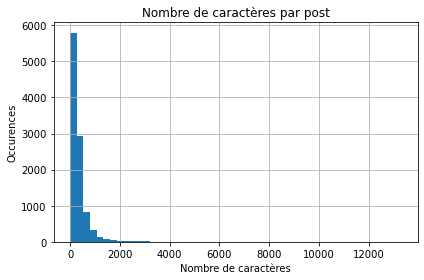

In [41]:
preprocessed_data['post_char_count'].hist(bins=50)
plt.xlabel('Nombre de caractères')
plt.ylabel('Occurences')
plt.title('Nombre de caractères par post')
plt.tight_layout()
plt.gcf().savefig('post_char_count', dpi=100)
plt.show()

In [42]:
preprocessed_data['post_char_count'].describe()

count    10243.000000
mean       342.186859
std        410.887007
min          4.000000
25%        143.000000
50%        236.000000
75%        399.000000
max      13294.000000
Name: post_char_count, dtype: float64

### Nombre de mots par post

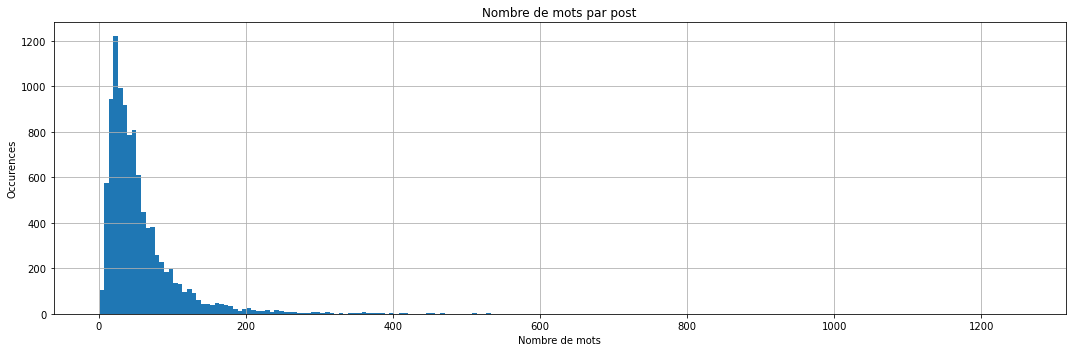

In [43]:
fig = plt.figure(figsize=(15, 5))
preprocessed_data['post_token_count'].hist(bins=200)
plt.title('Nombre de mots par post')
plt.xlabel('Nombre de mots')
plt.ylabel('Occurences')
plt.tight_layout()
plt.gcf().savefig('post_token_count', dpi=100)
plt.show()

In [44]:
preprocessed_data['post_token_count'].describe()

count    10243.000000
mean        56.666894
std         58.912455
min          1.000000
25%         25.000000
50%         41.000000
75%         68.000000
max       1252.000000
Name: post_token_count, dtype: float64

### Nombre de caractères moyen par mot

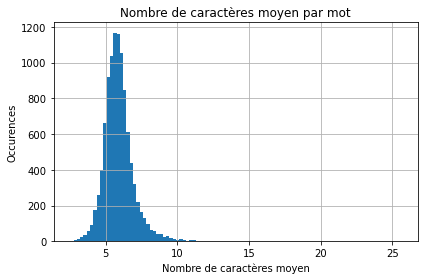

In [45]:
preprocessed_data['post_avg_wordlength'].hist(bins=100)
plt.xlabel('Nombre de caractères moyen')
plt.ylabel('Occurences')
plt.title('Nombre de caractères moyen par mot')
plt.tight_layout()
plt.gcf().savefig('post_avg_wordlength', dpi=100)
plt.show()

In [46]:
preprocessed_data['post_avg_wordlength'].describe()

count    10243.000000
mean         5.913813
std          1.088306
min          2.520000
25%          5.272727
50%          5.803738
75%          6.384615
max         25.606635
Name: post_avg_wordlength, dtype: float64

### Nombre de tags par post

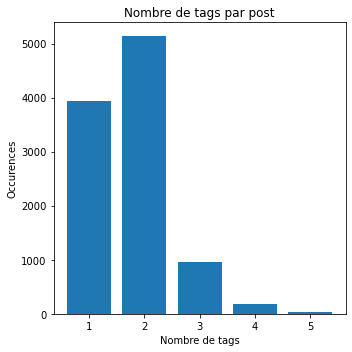

In [47]:
fig = plt.figure(figsize=(5, 5))
plt.bar(preprocessed_data['tags_number'].unique(), preprocessed_data['tags_number'].value_counts())
plt.title('Nombre de tags par post')
plt.xlabel('Nombre de tags')
plt.ylabel('Occurences')
plt.tight_layout()
plt.gcf().savefig('Nombre_tags_post', dpi=100)
plt.show()

In [48]:
preprocessed_data['tags_number'].describe()

count    10243.000000
mean         1.635654
std          0.746682
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: tags_number, dtype: float64

### Wordcloud

Création d'un nuage de mots pour obtenir une représentation visuelle des mots les plus courants.

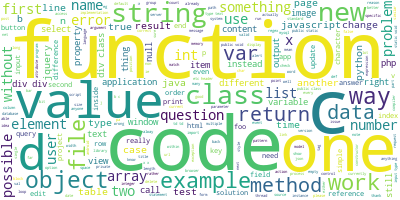

In [49]:
# Join the different processed texts together.
long_string = ','.join(preprocessed_data['str_tokens'].values)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000,
                      contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Tags par fréquence

Variable: Tags_list
Nombre de mots uniques: 50


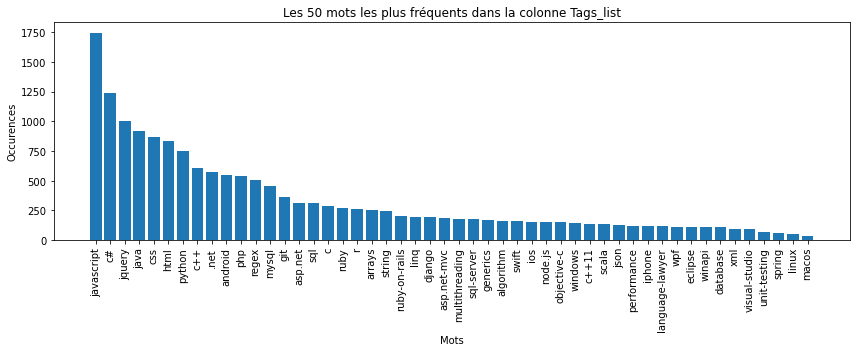

Nombre de mots rencontrés une seule fois: 0



{}

In [50]:
getFreq(preprocessed_data, 'Tags_list', 50, 50, False)

## Multivariée

### Corrélation entre les variables numériques

In [51]:
preprocessed_data.corr()

,tags_number,post_char_count,post_token_count,post_avg_wordlength
tags_number,1.000000,0.049386,0.061908,-0.027395
post_char_count,0.049386,1.000000,0.933719,0.321179
post_token_count,0.061908,0.933719,1.000000,0.110273
post_avg_wordlength,-0.027395,0.321179,0.110273,1.000000


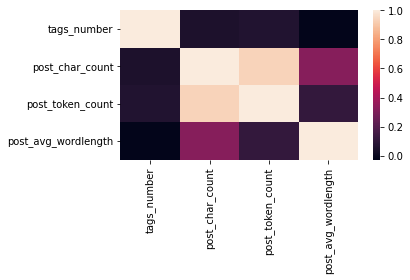

In [52]:
sns.heatmap(preprocessed_data.corr())
plt.tight_layout()
plt.savefig('sns.heatmap.png')

# Réduction dimensionnelle

## LDA

### Création des dictionnaires et corpus

In [53]:
# Build the bigram models
# higher threshold fewer phrases.
bigram = gensim.models.Phrases(preprocessed_data['list_tokens'], min_count=2, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)


def bigrams(df):
    return bigram_mod[df['list_tokens']]


preprocessed_data['list_tokens'] = preprocessed_data.apply(bigrams, axis=1)

In [54]:
# Create Dictionary
id2word = corpora.Dictionary(preprocessed_data['list_tokens'])

In [55]:
# Create Corpus
texts = preprocessed_data['list_tokens']

In [56]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### Recherche du nombre de topics optimal

In [57]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):

    coherence_values = []

    best_coherence = 0
    best_lda_params = {}
    best_lda = {}

    count = 0

    for num_topics in range(start, limit, step):
        best_coherence_topic = 0

        print(time.asctime(), 'Nombre de topics: ' + str(num_topics))

        for a in np.arange(0.01, 1, 0.49):
            for b in np.arange(0.01, 1, 0.49):
                count += 1

                model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics,
                                                        update_every=0,
                                                        chunksize=100,
                                                        passes=10,
                                                        alpha=a,
                                                        eta=b,
                                                        per_word_topics=False)

                coherencemodel = CoherenceModel(
                    model=model, texts=texts, dictionary=dictionary, coherence='c_v')

                if coherencemodel.get_coherence() > best_coherence_topic:
                    best_coherence_topic = coherencemodel.get_coherence()
                    best_lda['best_' + str(num_topics)] = model

                if coherencemodel.get_coherence() > best_coherence:
                    best_coherence = coherencemodel.get_coherence()
                    best_lda_params['count'] = count
                    best_lda_params['num_topics'] = num_topics
                    best_lda_params['alpha'] = a
                    best_lda_params['eta'] = b

        coherence_values.append(best_coherence_topic)

    return coherence_values, best_lda_params, best_lda

In [58]:
start = 10
limit = 51
step = 5

In [59]:
coherence_values, best_lda_params, best_lda = compute_coherence_values(
    dictionary=id2word, corpus=corpus, texts=preprocessed_data['list_tokens'], start=start, limit=limit, step=step)

Tue Feb 15 14:52:19 2022 Nombre de topics: 10
Tue Feb 15 15:00:12 2022 Nombre de topics: 15
Tue Feb 15 15:07:58 2022 Nombre de topics: 20
Tue Feb 15 15:15:52 2022 Nombre de topics: 25
Tue Feb 15 15:23:39 2022 Nombre de topics: 30
Tue Feb 15 15:31:30 2022 Nombre de topics: 35
Tue Feb 15 15:39:24 2022 Nombre de topics: 40
Tue Feb 15 15:47:10 2022 Nombre de topics: 45
Tue Feb 15 15:55:02 2022 Nombre de topics: 50


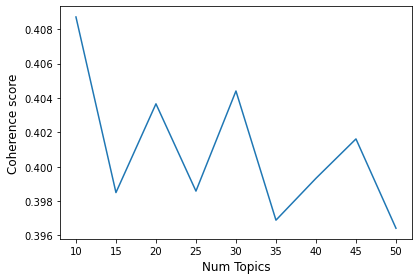

In [60]:
# Display results
fig = plt.figure(figsize=(16, 4))

x = range(start, limit, step)

ax = fig.add_subplot(1, 3, 1)
ax.plot(x, coherence_values)
ax.set_xlabel("Num Topics", fontsize=12)
ax.set_ylabel("Coherence score", fontsize=12)

plt.tight_layout()
plt.gcf().savefig('best_topics_nb', dpi=100)
plt.show()

In [61]:
best_lda_params

{'count': 9, 'num_topics': 10, 'alpha': 0.99, 'eta': 0.99}

In [62]:
best = 'best_30' #+ str(best_lda_params['num_topics'])

Point de sauvegarde

In [63]:
joblib.dump(best_lda[best], 'lda_model.jl')

['lda_model.jl']

### Analyse des résultats

In [64]:
lda_model = joblib.load('lda_model.jl')

#### Topic dominant par post

In [65]:
# Dominant topic per post
def get_dominant_topic(ldamodel, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num, 20)  # 20 words by topic
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series(
                    [int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic',
                              'Perc_Contribution', 'Topic_Keywords']

    return(sent_topics_df)

In [66]:
df_dominant_topic = get_dominant_topic(
    ldamodel=lda_model, corpus=corpus)

In [67]:
df_dominant_topic.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,14.0,0.8267,"function, option, string, c, name, select, typ..."
1,12.0,0.9782,"int, type, function, i_d, c, column, x, object..."
2,19.0,0.4992,"list, foo, like, jquery, code, function, user,..."
3,1.0,0.8220,"page, list, file, javascript, script, way, lik..."
4,0.0,0.9981,"c, value, int, function, x, bar, like, code, f..."


In [68]:
df_dominant_topic = df_dominant_topic.reset_index()
df_dominant_topic = drop(df_dominant_topic, ['index'])

In [69]:
preprocessed_data = preprocessed_data.reset_index()
preprocessed_data = drop(preprocessed_data, ['index'])

In [70]:
preprocessed_data = pd.concat([preprocessed_data, df_dominant_topic], axis=1, verify_integrity=True)

In [71]:
preprocessed_data.head()

,Tags_list,tags_number,text,list_tokens,str_tokens,post_char_count,post_token_count,post_avg_wordlength,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,"[c++, c]",2,Strange C++ errors with code that has min()/ma...,"[strange, c, error, code, min_max, call, stran...",strange c error code min max call strange erro...,65,16,4.062500,14.0,0.8267,"function, option, string, c, name, select, typ..."
1,"[c#, .net]",2,sizeof() equivalent for reference types? <p>I'...,"[sizeof, equivalent, reference, type, way, siz...",sizeof equivalent reference type way size inst...,80,13,6.153846,12.0,0.9782,"int, type, function, i_d, c, column, x, object..."
2,"[c#, windows]",2,Programmatically Determine a Duration of a Loc...,"[programmatically, duration, workstation, one,...",programmatically duration workstation one code...,242,38,6.368421,19.0,0.4992,"list, foo, like, jquery, code, function, user,..."
3,[asp.net],1,Can't get my event to fire <p>When loading a p...,"[event, fire, loading, page, first, time, ispo...",event fire loading page first time ispostback ...,116,21,5.523810,1.0,0.8220,"page, list, file, javascript, script, way, lik..."
4,[visual-studio],1,C# 2008 Express: Project type (.csproj) is not...,"[c, project, type, csproj, version, applicatio...",c project type csproj version application proj...,1021,172,5.936047,0.0,0.9981,"c, value, int, function, x, bar, like, code, f..."


In [72]:
preprocessed_data.shape

(10243, 11)

In [73]:
preprocessed_data.isnull().any()

Tags_list              False
tags_number            False
text                   False
list_tokens            False
str_tokens             False
post_char_count        False
post_token_count       False
post_avg_wordlength    False
Dominant_Topic         False
Perc_Contribution      False
Topic_Keywords         False
dtype: bool

#### Visualisation des mots clés par topic

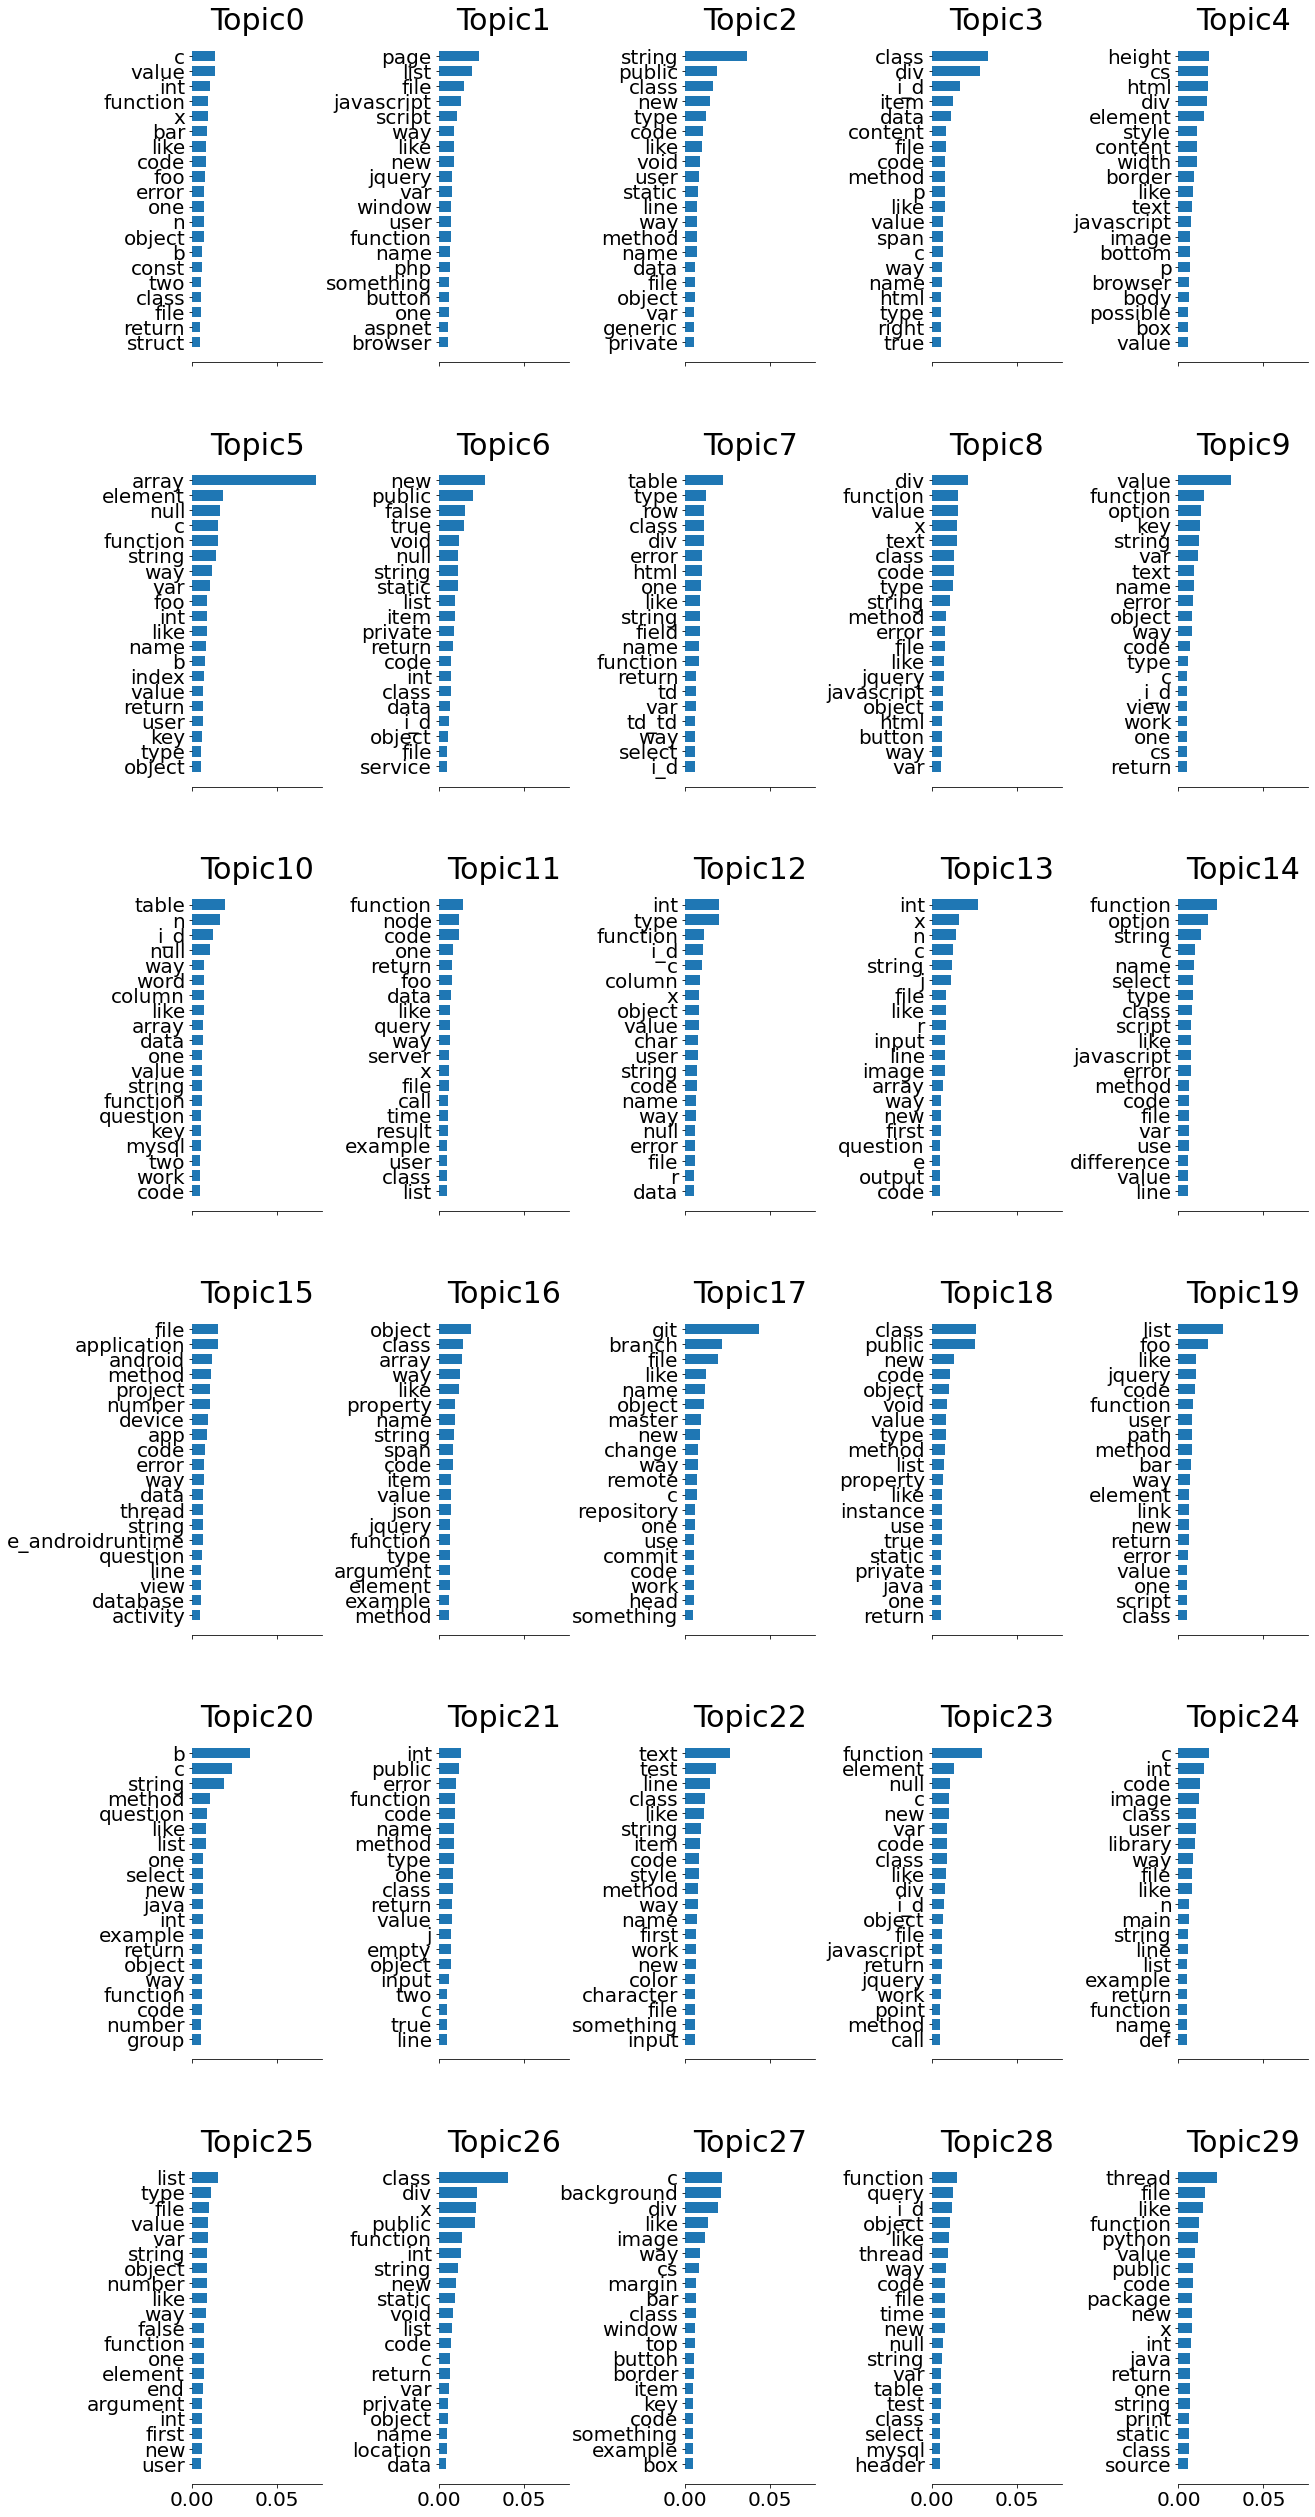

In [74]:
fig, axes = plt.subplots(6, 5, figsize=(20, 40), sharex=True)
axes = axes.flatten()

for i in range(0, lda_model.num_topics):
    topic = lda_model.show_topic(i, 20)

    top_features = []
    weights = []

    for (word, prop) in topic:
        top_features.append(word)
        weights.append(prop)

    ax = axes[i]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title('Topic' + str(i), fontdict={"fontsize": 30})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.show()

#### Tags présents dans topic keywords

In [75]:
def taginTopicKeywords(df, num):
    keywords = df['Topic_Keywords'].replace(' ', '').split(',')

    try:
        tag = df['Tags_list'][num]
    except IndexError:
        return 0

    if tag in keywords:
        return 1
    else:
        return 0


for i in range(0, 5):
    preprocessed_data['tag' +
         str(i) + 'inTopicKeywords'] = preprocessed_data.apply(taginTopicKeywords, num=i, axis=1)

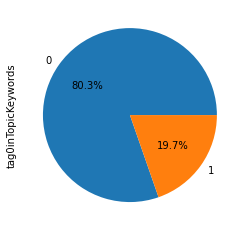

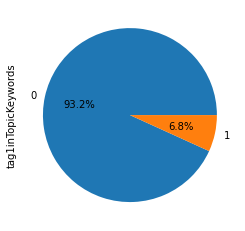

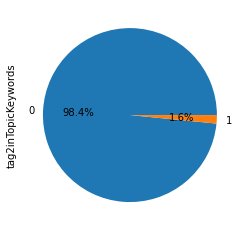

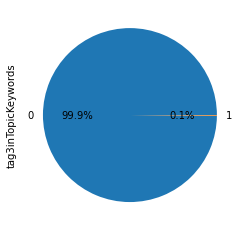

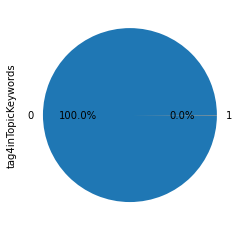

In [76]:
for i in range(0, 5):
    preprocessed_data['tag' + str(i) + 'inTopicKeywords'].value_counts(
        normalize=False).plot(kind='pie', autopct='%1.1f%%')
    plt.show()

### Topic - LDA vecteur

In [77]:
def topic(df, num):
    record = df['vector']
    return record[num]

In [78]:
train_vecs = []
for i in range(len(preprocessed_data)):
    top_topics = lda_model.get_document_topics(
        corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(lda_model.num_topics)]
    train_vecs.append(topic_vec)

In [79]:
preprocessed_data['vector'] = train_vecs

In [80]:
new_col_list = []

for i in range(0, lda_model.num_topics):
    preprocessed_data['topic_' + str(i)] = preprocessed_data.apply(topic, num=i, axis=1)
    new_col_list.append('topic_' + str(i))

# Sauvegarde du dataframe

In [82]:
col_filter = ['text', 'list_tokens', 'str_tokens', 'Dominant_Topic', 'Perc_Contribution']

col_filter.extend(new_col_list)
col_filter.extend(['Tags_list'])

In [83]:
df_save = preprocessed_data[col_filter]

In [84]:
df_save.head()

,text,list_tokens,str_tokens,Dominant_Topic,Perc_Contribution,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,Tags_list
0,Strange C++ errors with code that has min()/ma...,"[strange, c, error, code, min_max, call, stran...",strange c error code min max call strange erro...,14.0,0.8267,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,0.785559,0.000699,0.000699,0.000699,0.000699,0.000699,0.194855,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,0.000699,"[c++, c]"
1,sizeof() equivalent for reference types? <p>I'...,"[sizeof, equivalent, reference, type, way, siz...",sizeof equivalent reference type way size inst...,12.0,0.9782,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.978194,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,0.000752,"[c#, .net]"
2,Programmatically Determine a Duration of a Loc...,"[programmatically, duration, workstation, one,...",programmatically duration workstation one code...,19.0,0.4992,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.208561,0.000262,0.505916,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.278459,0.000262,0.000262,0.000262,"[c#, windows]"
3,Can't get my event to fire <p>When loading a p...,"[event, fire, loading, page, first, time, ispo...",event fire loading page first time ispostback ...,1.0,0.8220,0.000519,0.819091,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.166381,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,0.000519,[asp.net]
4,C# 2008 Express: Project type (.csproj) is not...,"[c, project, type, csproj, version, applicatio...",c project type csproj version application proj...,0.0,0.9981,0.998119,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,[visual-studio]


In [85]:
df_save.to_pickle('df_save.pkl')